In [20]:
import json
# import requests
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import pandas as pd
import pickle
from constants import *
# import rioxarray as rxr
from pyproj import crs
import os
import glob
from shapely.geometry import Point
import requests
import rasterio as rio
#import pygeos
import geopandas as gpd, geopandas

geopandas.options.use_pygeos = False

homedir = '/home/marianne/Documents/snow_fires/'
rawdatadir = '/home/marianne/Documents/data/'
datadir = homedir + 'data/'
# homedir = '/global/home/users/cowherd/snow_fires/'
# rawdatadir = '/global/scratch/users/cowherd/'

os.chdir(homedir)

wgs_crs = crs.CRS('epsg:4326')
use_crs = wgs_crs

#from load_data import *
## gives fires_allyears, wfigs20, gages_metadata, bas_all, gaged_basins_gdf, snowzone
## all in wgs crs


In [4]:
with open(datadir + 'gaged_basins.pickle', 'rb') as handle:
    gaged_basins = pickle.load(handle)
  
#with open(datadir + 'streamflow_metadata.pickle', 'rb') as handle:
#    streamflow_metadata = pickle.load(handle)
    
with open(datadir + 'target_basins.pickle', 'rb') as handle:
    target_basins = pickle.load(handle)

In [3]:
## target watersheds for the SNSR
names = ['East Branch N. Fork Feather',
         'Upper Mokelumne',
         'Upper Merced',
         'Upper Kaweah',
         'Upper Tule',
         'Upper Kern',
         'South Fork Kern'
        ]
gage_ids = [11402000,
            11318500,
            11266500,
            11208000,
            11202710,
            11185500,
            11189500
           ]
target_gages = pd.DataFrame({
    'name':names,
    'gage_id':gage_ids
})

In [18]:
'''allgages = gpd.read_file(datadir + 'gagesii/gagesII_9322_sept30_2011.shp')
## are all of them already in my metadata file from before?
pts = []
for i in range(len(target_gages)):
    g = target_gages['gage_id'][i]
    tmp = allgages[allgages['STAID']==str(g)]
    if len(tmp)==0:
        print('no ' + str(g))
        pts.append(np.nan)
    else:
        pts.append(tmp['geometry'].to_crs('epsg:4326'))'''

## did some copypasting to get below

In [4]:
lats=[-120.95440,
-120.54548,
-119.66628,
-118.79927,
-118.70954,
-118.467586, 
-118.17369]
lons=[40.00295,
38.36825,
37.71687,
36.52189,
36.16134,
35.90550439,
35.73745]

points = [Point(xy) for xy in zip(lats,lons)]

In [5]:
data = {
    'gage_id':target_gages['gage_id'],
    'name':target_gages['name']}
target_gages = gpd.GeoDataFrame(data= data,geometry= points)

ids = [str(val) for val in bas_all['GAGE_ID']]
target_basins = gpd.GeoDataFrame()
for i in range(len(target_gages)):
    g = str(target_gages['gage_id'][i])
    data = bas_all.loc[(bas_all['GAGE_ID']==g)]
    if len(data)==0: 
        print('no watershed '+ g )
    else: 
        print('yes watershed ' + g)
        target_basins = pd.concat([target_basins, data])

with open(datadir + 'target_basins.pickle', 'wb') as handle:
    pickle.dump(target_basins, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
target_basins_gdf = gpd.GeoDataFrame(data = target_basins[['AREA','PERIMETER','GAGE_ID']],geometry = target_basins['geometry'])
target_basins_gdf.to_file(datadir + 'target_basins.gdf')

target_basins = target_basins_gdf

## 11185500 no basin found? this is on the upper kern

yes watershed 11402000
yes watershed 11318500
yes watershed 11266500
yes watershed 11208000
yes watershed 11202710
no watershed 11185500
yes watershed 11189500


/global/home/users/cowherd/.conda/envs/snow/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


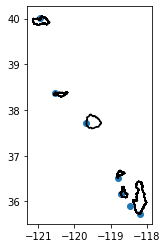

In [6]:
fig,ax = plt.subplots()
target_gages.plot(ax=ax)
target_basins.boundary.plot(ax=ax,color='k')
plt.show()
## add in the contextily background some other time, package isn't going well rn

In [5]:
## function that gets the streamflow data from a given site
def get_details (site, start_date, end_date):
    url = 'https://nwis.waterservices.usgs.gov/nwis/iv/?site={site}&startDT={start}&endDT={end}&parameterCD=00060&format=json'.format(site=site, start=start_date, end=end_date)
    req = requests.get(url)

    if req.status_code != 200 :
        print('request has returned with status {}'.format(req.status_code))
        return

    resp_data = json.loads(req.text)
    # I need the data itself, the bad value, unit, variable description and name
    # discard unneeded data
    resp_data = resp_data['value']['timeSeries'][0]

    # begin building what I'll return
    good_data = {}
    # I will use this to keep track of any problems that I don't want to stop on
    good_data['problems'] = []

    # get site number (I want to be sure they match)
    site_num = resp_data['sourceInfo']['siteCode'][0]['value']
    good_data['site_num'] = site_num
    if site_num != site :
        good_data['problems'].append('Site number in response {} does not match given {}'.format(site_num, site))

    # get site name
    good_data['siteName'] = resp_data['sourceInfo']['siteName']

    # get huc code
    huc_code = next(i for i in resp_data['sourceInfo']['siteProperty'] if i['name'] == 'hucCd')
    good_data['huc_code'] = huc_code['value']

    # get no-data value
    no_value = resp_data['variable']['noDataValue']

    # get variable description
    var_description = resp_data['variable']['variableDescription']
    good_data['var_description'] = var_description

    # get datapoints
    good_data['series'] = []
    good_data['value'] = []
    good_data['datetime'] = []
    for item in resp_data['values'][0]['value'] :
        if item['value'] == no_value:
            item['value'] = None
        del item['qualifiers']
        good_data['series'].append(item)
        good_data['value'].append(item['value'])
        good_data['datetime'].append(item['dateTime'])
        
    df = pd.DataFrame(data = good_data['value'],index = good_data['datetime'],columns=['streamflow'])
    return good_data, df

In [8]:
## get streamflow data
start_date = '1900-01-01'
end_date = '2022-04-25'
test = target_basins.loc[6626]
site = test.GAGE_ID
data = get_details (site,start_date,end_date)

from dateutil import parser
dt = [parser.parse(i) for i in df.index]
df['dt'] = dt

NameError: name 'df' is not defined

In [ ]:
fig,ax = plt.subplots(figsize=(20,10))
ax.plot(df.dt, df['streamflow'].values.astype('float'),'-',label = 'test')
ax.set_ylabel('streamflow [cfs]')
plt.show()


In [22]:
## get streamflow data
start_date = '1900-01-01'
end_date = '2022-04-25'
test = target_basins.loc[6626]

data = pd.DataFrame(columns = target_basins.index)
for i in range(len(target_basins)):
    idx = target_basins.index[i]
    site = target_basins['GAGE_ID'][idx]
    df, newdata = get_details(site = site, start_date = start_date,end_date=end_date)
    data[idx] = df.values()

IndexError: list index out of range

In [21]:
newdata

,streamflow
1987-10-01T00:15:00.000-07:00,19.0
1987-10-01T00:30:00.000-07:00,19.0
1987-10-01T00:45:00.000-07:00,19.0
1987-10-01T01:00:00.000-07:00,19.0
1987-10-01T01:15:00.000-07:00,20.0
...,...
2022-04-25T22:45:00.000-07:00,409
2022-04-25T23:00:00.000-07:00,409
2022-04-25T23:15:00.000-07:00,400
2022-04-25T23:30:00.000-07:00,404
